# Determining $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ of DESIJ1101-0602

**Author(s)**: S M Rafee Adnan, Sulyman Hossain, Anowar Shajib <br>
**Acknowledgement(s)**: Ahmad Al - Imtiaz

## Load data

In [1]:
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [3]:
data, header = fits.getdata("/kaggle/input/fits-file/DESIJ1101-0602_F140W_drz_sci.fits", header=True)

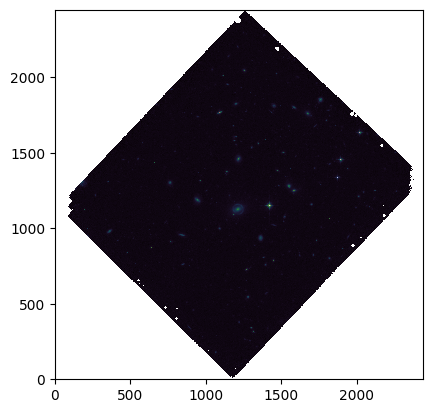

In [4]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [5]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/tmp/ipykernel_19/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


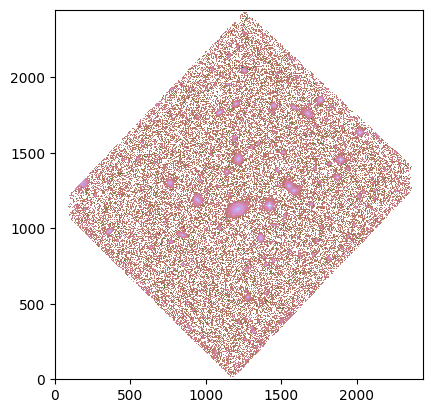

In [6]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [7]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.36766940932551023, 0.01676079434804679)

In [8]:
bkg_subtracted_data = data - bkg.background

In [9]:
threshold = 3 * bkg.background_rms

In [10]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [11]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [12]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2448, 2439)
nlabels: 796
labels: [  1   2   3   4   5 ... 792 793 794 795 796]


In [13]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 796
labels: [  1   2   3   4   5 ... 792 793 794 795 796]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [14]:
set_x_lim1, set_x_lim2 = 850, 1550
set_y_lim1, set_y_lim2 = 800, 1400

/tmp/ipykernel_19/66409615.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


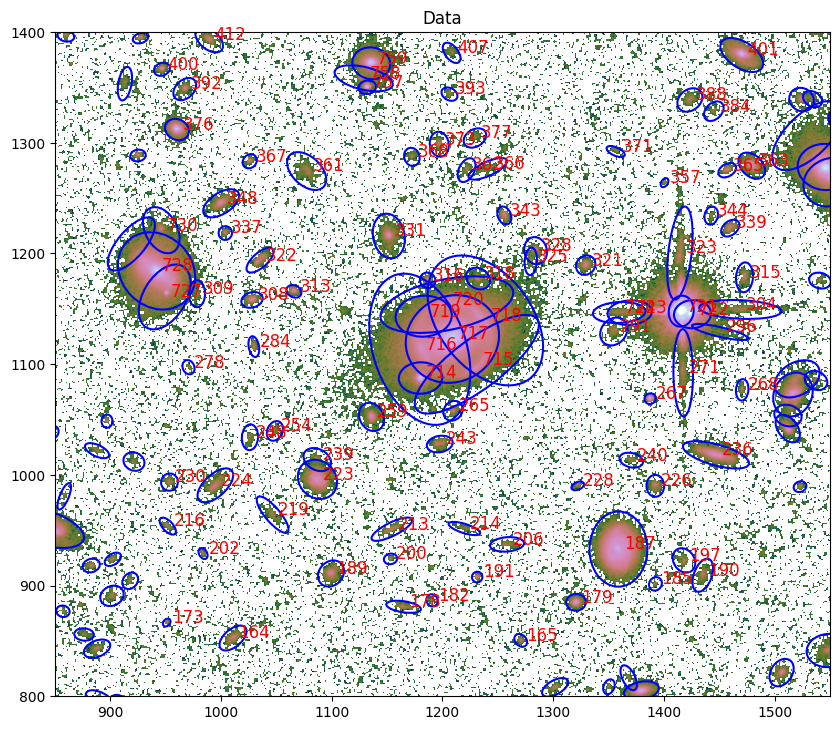

In [15]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

# # Before determining the central ID
# for i in range(len(cat)):
#     ax1.text(
#         cat.xcentroid[i] + 5,
#         cat.ycentroid[i],
#         f"{i}",
#         c="r",
#         fontsize=12
#     )

# After determining the central ID
id_central = 717
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 280
        and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 280
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/tmp/ipykernel_19/3133394023.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


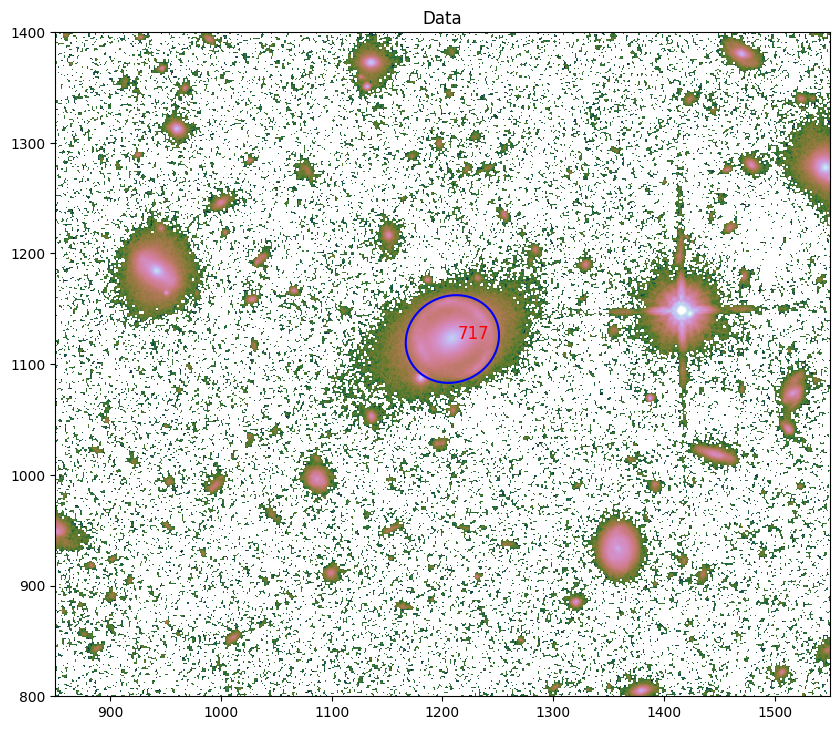

In [16]:
# object id of your central deflector/lens
id_central = 717
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12,
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [17]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [18]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (
        np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08
    ):  # Find neighbouring galaxies within 20 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 30 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 30 arcsecond radius: 124


In [19]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 30 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 30 arcsecond radius: 36


## Pixels to Megaparsec unit

In [20]:
def distance_parsec(pixel_distance):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180
    
    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian
    
    # Define cosmological parameters
    H0 = 70   # Hubble constant in km/s/Mpc
    Om0 = 0.3 # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Define the redshifts at which you want to compute the angular diameter distance
    z = 0.581
    
    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)
    
    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian 

    return physical_distances_mpc

In [21]:
# list of galaxies you want removed
remove_list = [
    717,  # This is the central deflector
    715,  # Object is part of the lensed arc
    716,  # Object is part of the lensed arc
    718,  # Object is part of the lensed arc
    719,  # Object is part of the lensed arc
    720,  # Object is part of the lensed arc
    721,  # Object is a star
    722,  # Object is part of diffraction spikes of a star
    723,  # Object is part of diffraction spikes of a star
    724,  # Object is part of diffraction spikes of a star
    323,  # Object is part of diffraction spikes of a star
    713,  # Spiral arm of Object ID 712
]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratio
714         45.513320              0.023977  169.025157    0.722749
316         57.564132              0.030325    8.498388    0.944349
318         59.342924              0.031263   10.886782    0.800786
265         64.819683              0.034148    7.758918    0.847120
243         95.544265              0.050334   10.113676    0.626044
325         99.662522              0.052503    4.132066    0.444938
259        101.435229              0.053437   28.924874    0.801214
331        109.297809              0.057579   41.697822    0.697494
328        109.590882              0.057734    9.869706    0.817106
343        121.066388              0.063779   10.124112    0.704402
321        137.647078              0.072514   12.825017    0.894488
291        145.921916              0.076873    7.922509    0.817526
313        149.458019              0.078736   10.058066    0.764407
362        153.099680              0.080655    4

In [22]:
remove_list_1 = [
    717,  # This is the central deflector
    715,  # Object is part of the lensed arc
    716,  # Object is part of the lensed arc
    718,  # Object is part of the lensed arc
    719,  # Object is part of the lensed arc
    720,  # Object is part of the lensed arc
    721,  # Object is part of diffraction spikes of a star
    722,  # Object is part of diffraction spikes of a star
    323,  # Object is part of diffraction spikes of a star
    713,  # Spiral arm of Object ID 712
]
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)         Flux  Axis Ratio
714         45.513320              0.023977   169.025157    0.722749
259        101.435229              0.053437    28.924874    0.801214
331        109.297809              0.057579    41.697822    0.697494
223        175.858854              0.092644   116.778409    0.866130
267        186.494616              0.098247    23.726444    0.924064
189        238.483260              0.125636    21.974665    0.828810
757        240.074656              0.126474    36.509799    0.748754
187        241.850301              0.127410   702.572242    0.770253
348        242.194898              0.127591    29.814222    0.518361
224        251.634187              0.132564    20.344418    0.497902
759        259.615225              0.136768   203.586431    0.830409
236        260.067794              0.137007   101.152538    0.304869
727        262.618985              0.138351    75.249699    0.597114
179        262.739947             

## Visualizing removed objects (except central deflector)

/tmp/ipykernel_19/303734189.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


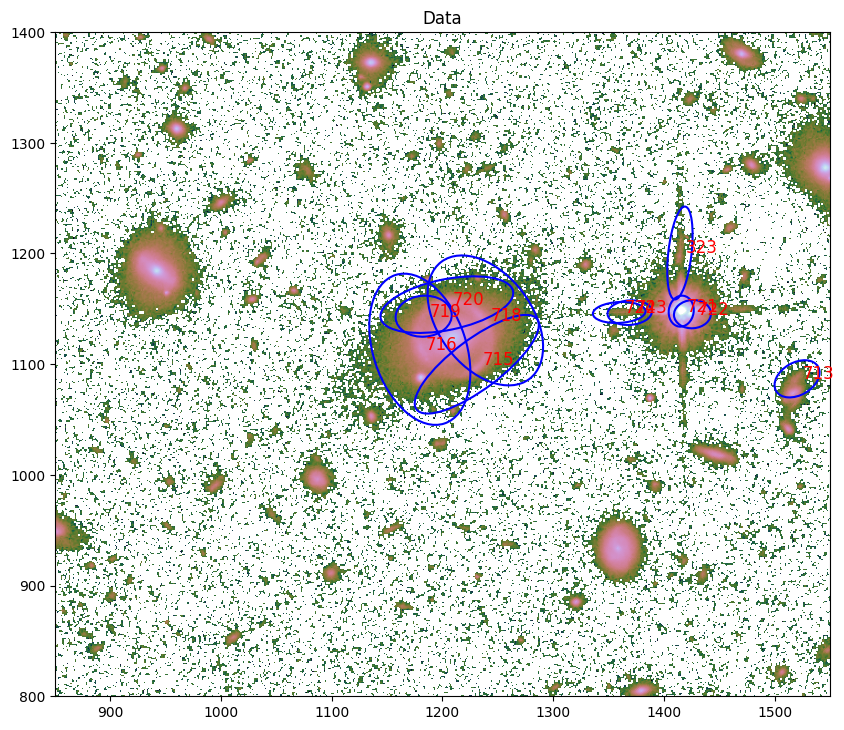

In [23]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

remove_list_exc_central = remove_list
if id_central in remove_list_exc_central:
    remove_list_exc_central.remove(id_central)

updated_remove_list = [s + 1 for s in remove_list_exc_central]
cat_subset_removed = cat.get_labels(updated_remove_list)
cat_subset_removed.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in remove_list:
    ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Visualization

/tmp/ipykernel_19/432903831.py:19: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_19/432903831.py:22: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_19/432903831.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_19/432903831.py:28: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


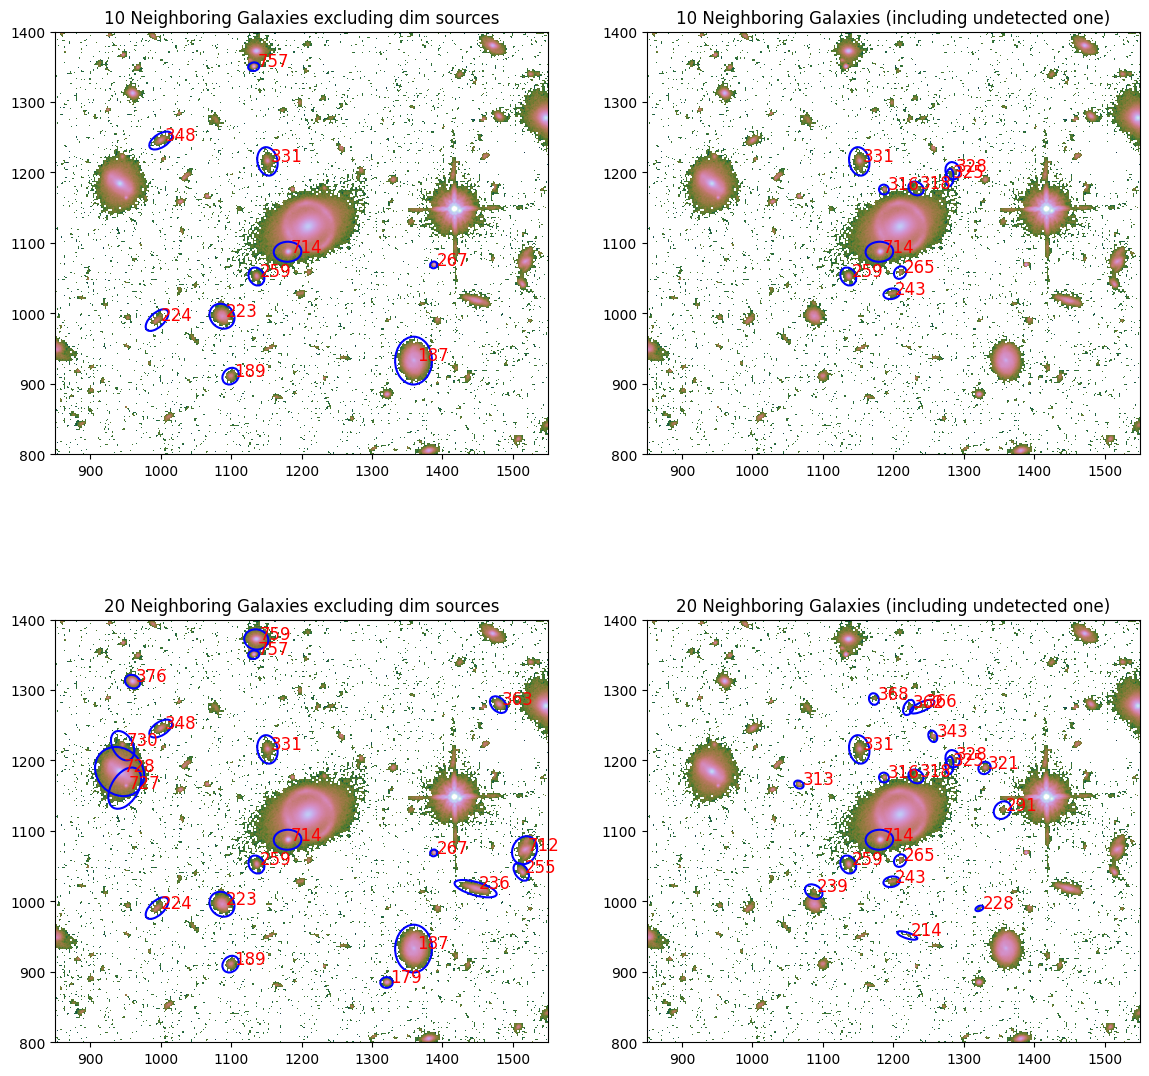

In [24]:
close_ids_all = list(df_all_20.index.values)
close_ids_all.pop(19)
close_ids_all_10 = close_ids_all[:10]
close_ids_all_10.pop(9)

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:9]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies (including undetected one)")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies (including undetected one)")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Loading Global Mean

In [25]:
# Read flux data from each YAML file and append to corresponding lists
input_path = f"/kaggle/input/global-means/DESIJ1101-0602_means.yml"

try:
    with open(input_path, "r") as f:
        data_mean = yaml.safe_load(f)
except (AttributeError, yaml.YAMLError) as e:
    print(f"Failed to load {lens_name}: {e}")
    
global_mean_flux_10 = data_mean.get("Global_mean_flux_10")
global_mean_flux_20 = data_mean.get("Global_mean_flux_20")
global_mean_flux_selected_10 = data_mean.get("Global_mean_flux_selected_10")
global_mean_flux_selected_20 = data_mean.get("Global_mean_flux_selected_20")
global_mean_flux_dis_10 = data_mean.get("Global_mean_flux_dis_10")
global_mean_flux_dis_20 = data_mean.get("Global_mean_flux_dis_20")
global_mean_flux_dis_selected_10 = data_mean.get("Global_mean_flux_dis_selected_10")
global_mean_flux_dis_selected_20 = data_mean.get("Global_mean_flux_dis_selected_20")

## Method A

In [26]:
# For all sources
R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.06377915667571586
R 20: 0.09264445356067838
Sigma 10: 782.5148398568465
Sigma 20: 741.7221948923884

EXCLUDING DIM SOURCES
R 10: 0.13256376476796697
R 20: 0.1651527795123639
Sigma 10: 181.13420465733864
Sigma 20: 233.4040289779945


## Method B

In [27]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10] / global_mean_flux_10)
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20] / global_mean_flux_20)
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10] / global_mean_flux_selected_10)
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20] / global_mean_flux_selected_20)
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.06377915667571586
R 20: 0.09264445356067838
Sigma 10_updated: 194.6066577353562
Sigma 20_updated: 195.246341096068

EXCLUDING DIM SOURCES
R 10: 0.13256376476796697
R 20: 0.1651527795123639
Sigma 10_updated: 106.3019792245963
Sigma 20_updated: 205.69167173907852


## Method C

In [28]:
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# for all sources
for i in range(20):
    flux_all = df_all_20["Flux"][i:i+1] / df_all_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_d_10_all.append(flux_all)
        flux_d_20_all.append(flux_all)
        
    elif 9 < i < 20:
        flux_d_20_all.append(flux_all)
        
weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_dis_20
Sigma_10_allC = weighted_flux_10_all  / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i:i+1] / df_1_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_d_10_1.append(flux_1)
        flux_d_20_1.append(flux_1)
        
    elif 9 < i < 20:
        flux_d_20_1.append(flux_1)
        
weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_dis_selected_20
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)

print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06377915667571586
R 20: 0.09264445356067838
Sigma 10_updated: 147.86393792450644
Sigma 20_updated: 141.75115172365244

EXCLUDING DIM SOURCES
R 10: 0.13256376476796697
R 20: 0.1651527795123639
Sigma 10_updated: 47.61154336498134
Sigma 20_updated: 90.08006868200037


## Method D

In [29]:
# Initialize flux variables
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# Define a short radius
pixel_distance = 125 # for 10 arcseconds
s = distance_parsec(pixel_distance).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]
    
    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_d_10_all.append(flux_contrib_all)
        flux_d_20_all.append(flux_contrib_all)
        
    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_d_20_all.append(flux_contrib_all)
    
    # Processing for df_1_20
    if i < 10:
        
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_d_10_1.append(flux_contrib_1)
        flux_d_20_1.append(flux_contrib_1)
        
    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_d_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_dis_20
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_dis_selected_20
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)


# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)



Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06377915667571586
R 20: 0.09264445356067838
Sigma 10_updated: 69.11485819480384
Sigma 20_updated: 78.7594554122457

EXCLUDING DIM SOURCES
R 10: 0.13256376476796697
R 20: 0.1651527795123639
Sigma 10_updated: 33.854308892479104
Sigma 20_updated: 75.42727427476218


## Save the final deriverables to the YAML file

In [30]:
import shutil
src_path = r"/kaggle/input/point-estimates/DESIJ1101-0602_point_estimates.yml"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1101-0602_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

## Determining the mean for normalizing

In [31]:
#Mean of Fluxes
flux_10_mean = np.mean(df_all_20["Flux"][0:9])
flux_20_mean = np.mean(df_all_20["Flux"][0:19])
flux_10_1_mean = np.mean(df_1_20["Flux"][0:9])
flux_20_1_mean = np.mean(df_1_20["Flux"][0:19])

#Mean of Flux/Distance
flux_d_10_mean = np.mean(flux_d_10_all)
flux_d_20_mean = np.mean(flux_d_20_all)
flux_d_10_1_mean = np.mean(flux_d_10_1)
flux_d_20_1_mean = np.mean(flux_d_20_1)

print(flux_10_mean, flux_20_mean, flux_10_1_mean, flux_20_1_mean)
print(flux_d_10_mean, flux_d_20_mean, flux_d_10_1_mean, flux_d_20_1_mean)

32.32304317426904 18.694958336135198 130.11373718364624 157.33507280328035
457.1373906289385 325.6193583270983 1150.6223379069866 1203.4497193164295


In [32]:
mean_variables = {
    "Flux_10b_mean": flux_10_mean,
    "Flux_20b_mean": flux_20_mean,
    "Flux_selected_10b_mean": flux_10_1_mean,
    "Flux_selected_20b_mean": flux_20_1_mean,
    
    "Flux_dis_10_mean": flux_d_10_mean,
    "Flux_dis_20_mean": flux_d_20_mean,
    "Flux_dis_10_1_mean": flux_d_10_1_mean,
    "Flux_dis_20_1_mean": flux_d_20_1_mean
}

# make all the numpy variales to float
mean_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in mean_variables.items()
}

In [33]:
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1101-0602_means.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(mean_variables, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ1101-0602_means.yml' created successfully.
